Machine Learning Project
(by Carlos María del Pino and Lamlih Houssam)
In this part of the projet, we make all the data process. We try to analyze and conlude facts from the features

1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, log_loss)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

2. Reading the data and plotting some of lines

In [2]:
df_train = pd.read_csv('data/train.csv')
df_train.dropna(subset=['Y'], inplace=True)

X_train = df_train.drop('Y', axis = 1)
y_train = df_train['Y']


X_test = pd.read_csv('data/Xtest.csv')
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,3215.0,206.0,8.0,127.0,14.0,5588.0,215.0,248.0,168.0,1057.0,T1,T29,1.0
1,3022.0,18.0,7.0,0.0,0.0,3012.0,215.0,226.0,148.0,1476.0,T1,T23,1.0
2,3008.0,18.0,19.0,382.0,92.0,4715.0,201.0,197.0,127.0,3616.0,T1,T29,1.0
3,2595.0,296.0,24.0,85.0,28.0,1252.0,144.0,224.0,216.0,780.0,T3,T33,6.0
4,3261.0,87.0,4.0,42.0,-2.0,3719.0,226.0,233.0,142.0,3784.0,T1,T38,7.0


In [3]:
X_train.isna().count()

X1     40632
X2     40632
X3     40632
X4     40632
X5     40632
X6     40632
X7     40632
X8     40632
X9     40632
X10    40632
X11    40632
X12    40632
dtype: int64

In [4]:
X_train.dtypes

X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
X6     float64
X7     float64
X8     float64
X9     float64
X10    float64
X11     object
X12     object
dtype: object

In [6]:
X_train = X_train.astype({'X11':'category', 'X12': 'category'})
X_test = X_test.astype({'X11':'category', 'X12':'category'})

In [7]:
print(X_train.dtypes)

X1      float64
X2      float64
X3      float64
X4      float64
X5      float64
X6      float64
X7      float64
X8      float64
X9      float64
X10     float64
X11    category
X12    category
dtype: object


Plot a bar chart in order to visualize better the possible predictions

<Axes: xlabel='Y', ylabel='count'>

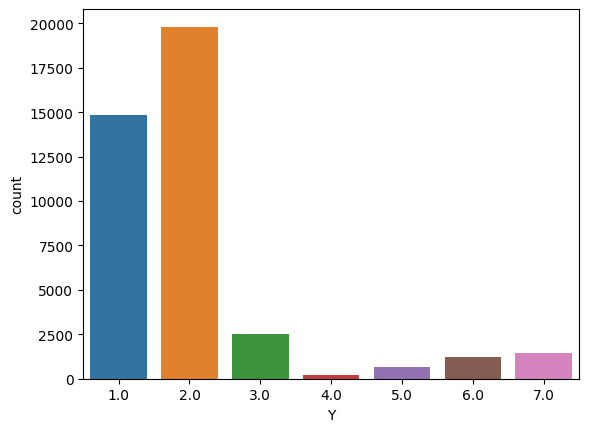

In [8]:
sns.countplot(x=y_train)

We can observe the vast majority of the example are classified as Y=2, so that could be a issue to take into acount. we are now gonnas study how the data is distributed and which variables are better to select as predictors

Printing now how the categorical variables are distributed

In [9]:
print(X_train.X11.value_counts())
print(X_train.X12.value_counts())

T1    18147
T3    17882
T4     2503
T2     2062
Name: X11, dtype: int64
T29    7996
T23    3972
T32    3723
T33    3180
T22    2325
T10    2300
T12    2128
T30    2113
T31    1806
T24    1468
T13    1278
T38    1058
T39     973
T11     913
T4      879
T40     644
T20     621
T2      540
T6      422
T3      319
T19     288
T17     241
T1      187
T26     187
T16     173
T35     127
T18     126
T34     110
T5       90
T9       84
T27      82
T28      63
T21      54
T14      49
T25      26
T37      18
T8       14
T36       9
T7        7
T15       1
Name: X12, dtype: int64


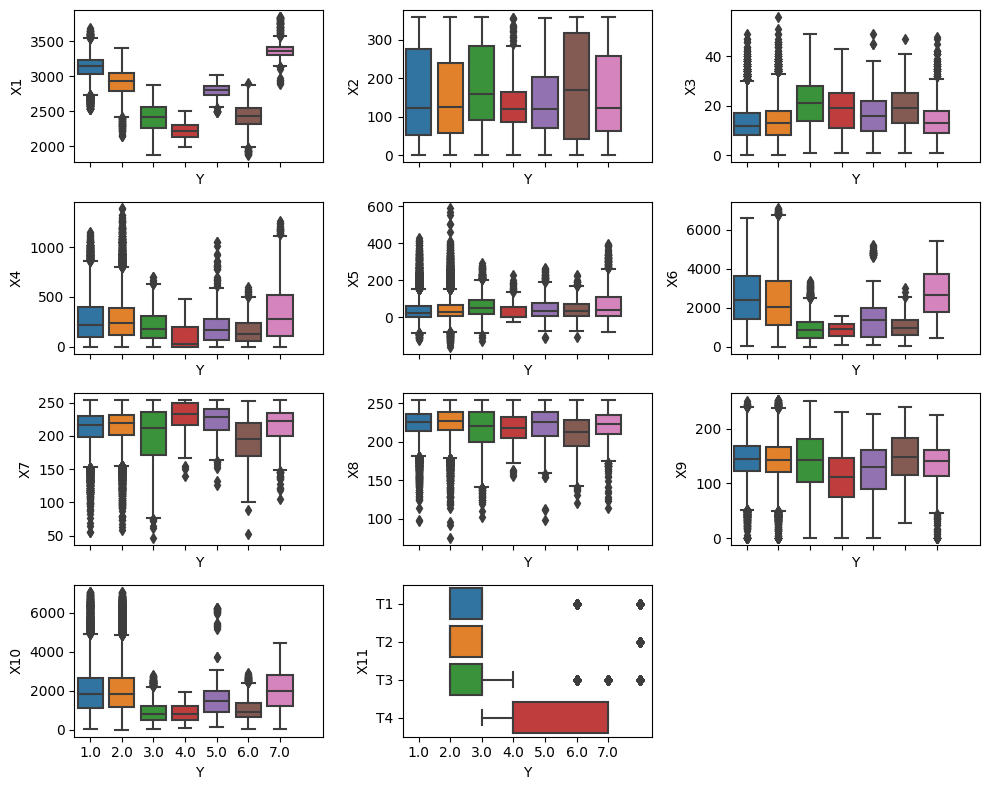

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharex=True)
for column, axis in zip(X_train.columns, axes.flatten()):
    sns.boxplot(x=y_train, y=X_train[column], ax=axis)
axes.flatten()[-1].set_visible(False)
#axes.flatten()[-2].set_visible(False)
fig.tight_layout()

C:\Users\cmari\AppData\Local\Temp\ipykernel_9476\2766184221.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X_train.corr ()


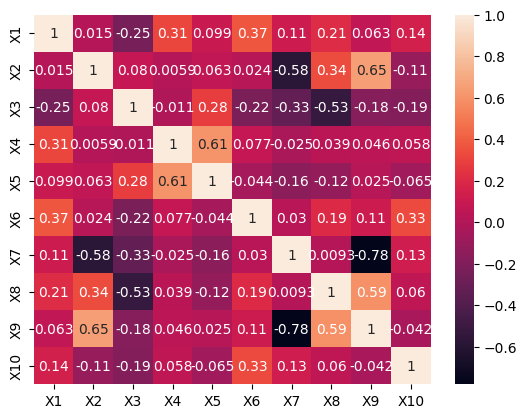

<Figure size 1500x800 with 0 Axes>

In [16]:
corr = X_train.corr ()
#orr.style.background_gradient(cmap = 'coolwarm')
sns.heatmap(corr, annot = True)
 
plt.figure(figsize=(15, 8))
plt.show()

Thanks to this diagram we can observe that variables such as X1, X6, X3 could be suitable for predicting Y. We can observe also X11 is not equal distributed between the different predictions, so we can take that into account.

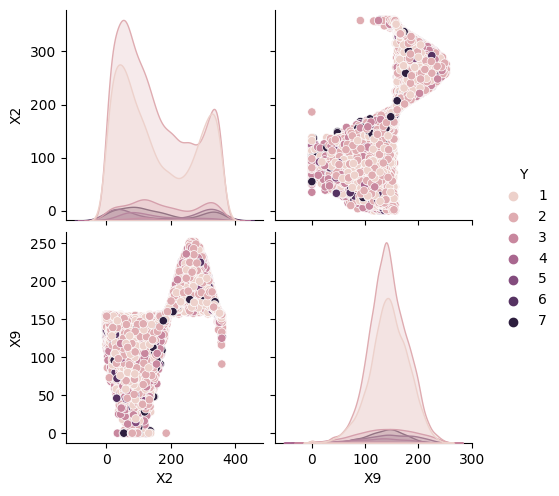

In [10]:
sns.pairplot(pd.concat([X_train[['X2', 'X9']], y_train], axis=1), hue='Y')

We can observe it is possible to have a positive relation between X1 and X6. We can't conlude anything more from the others variables. Now we are gonna preprocess the data scaling the features

From here to the end of the document, we explore different algorithms. We have done different notebooks in order to make it easier to understand.

We are gonna start trying to use the algorithm KNN, 

In [14]:
X_train_sub  = X_train[['X1', 'X3', 'X6', 'X11']]
X_test_sub = X_test[['X1', 'X3', 'X6', 'X11']]

numeric_features = ['X1', 'X3', 'X6']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['X11']
X_train_sub = X_train_sub.astype({'X11':'category'})
X_test_sub = X_test_sub.astype({'X11':'category'})

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
 
neighbors = [2, 3, 5, 10, 15, 20, 40, 80, 100]
log_losses = []
accuracies = []
for i in neighbors:
    print("Running Knn with "+str(i)+" neighbours")
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p=2)
    model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', knn)])

    model.fit(X_train_sub, y_train)
    #Compute the predicted probabilit  y for each class on the training set and evaluate on the log-loss.

    pred_prob_train = pd.DataFrame(model.predict_proba(X_train_sub))
    loss = log_loss(y_train, pred_prob_train)
    log_losses.append(loss)
    print(f'Training log-loss : {loss}')
    
    # We measure the test accuracy and log score.
    y_pred = model.predict(X_train_sub)
    test_accuracy = accuracy_score(y_pred, y_train)
    accuracies.append(test_accuracy)
    print('Accuracy:', test_accuracy)


    #Predict on the test predictors, and save the probabilities to a csv file. 
    
    pred_prob_test = pd.DataFrame(model.predict_proba(X_test_sub))

    pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
    idx = pred_prob_test.index
    pred_prob_test.insert(0, 'id', idx)
    pred_prob_test.head()
    

Running Knn with 2 neighbours
Training log-loss : 0.22443011191786505
Accuracy: 0.8395599527466037
Running Knn with 3 neighbours
Training log-loss : 0.32362709765010494
Accuracy: 0.8335548336286671
Running Knn with 5 neighbours
Training log-loss : 0.41673191601005616
Accuracy: 0.7974010632014176
Running Knn with 10 neighbours
Training log-loss : 0.5001109474071788
Accuracy: 0.7615180153573539
Running Knn with 15 neighbours
Training log-loss : 0.5354301135138465
Accuracy: 0.7497292774168144
Running Knn with 20 neighbours
Training log-loss : 0.5556566944862519
Accuracy: 0.7424936011025792
Running Knn with 40 neighbours
Training log-loss : 0.5973637564250105
Accuracy: 0.7269885804292183
Running Knn with 80 neighbours
Training log-loss : 0.6312231993138381
Accuracy: 0.7133786178381571
Running Knn with 100 neighbours
Training log-loss : 0.6406103541494668
Accuracy: 0.7088993896436306


We can observe having the algorithm with 5 neighbours coulb be a good option

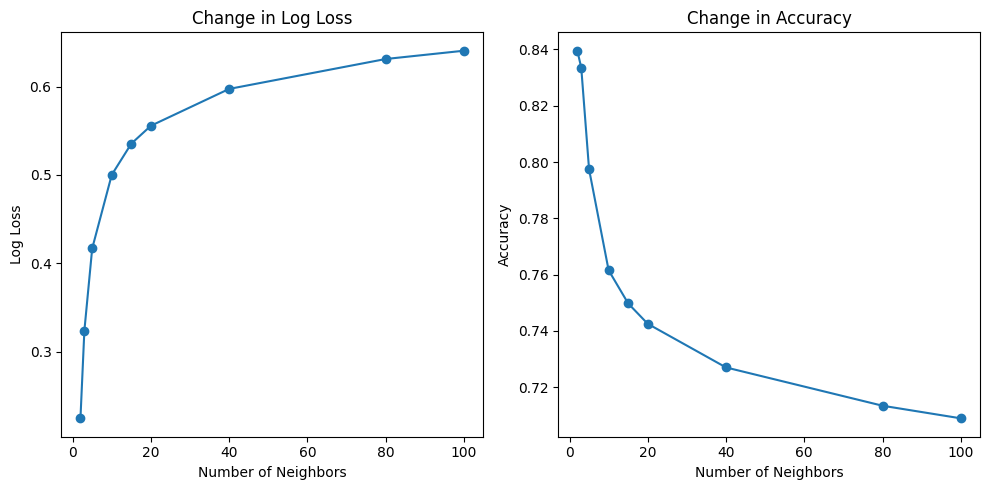

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(neighbors, log_losses, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Log Loss')
plt.title('Change in Log Loss')

plt.subplot(1, 2, 2)
plt.plot(neighbors, accuracies, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy')

plt.tight_layout()
plt.show()


In [85]:

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors=100, weights='uniform', p=2))])

model.fit(X_train_sub, y_train)

pred_prob_train = pd.DataFrame(model.predict_proba(X_train_sub))
loss = log_loss(y_train, pred_prob_train)
print(f'Training log-loss : {loss}')
    
# We measure the test accuracy and log score.
y_pred = model.predict(X_train_sub)

pred_prob_test = pd.DataFrame(model.predict_proba(X_test_sub))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()

Training log-loss : 0.6406103541494668


,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.19,0.81,0.0,0.0,0.00,0.00,0.00
1,1,0.15,0.83,0.0,0.0,0.02,0.00,0.00
2,2,0.55,0.45,0.0,0.0,0.00,0.00,0.00
3,3,0.14,0.76,0.0,0.0,0.05,0.05,0.00
4,4,0.59,0.37,0.0,0.0,0.00,0.00,0.04


In [86]:
print(confusion_matrix(y_pred, y_train))

[[10542  3526     0     0     4     0  1126]
 [ 4209 15856   522     0   577   268    25]
 [    8   371  1858   178     9   763     0]
 [    0     0     0     7     0     0     0]
 [    4    23     0     0    74     0     0]
 [    1    24   120     6     0   184     0]
 [   55     9     0     0     0     0   283]]


<Axes: ylabel='count'>

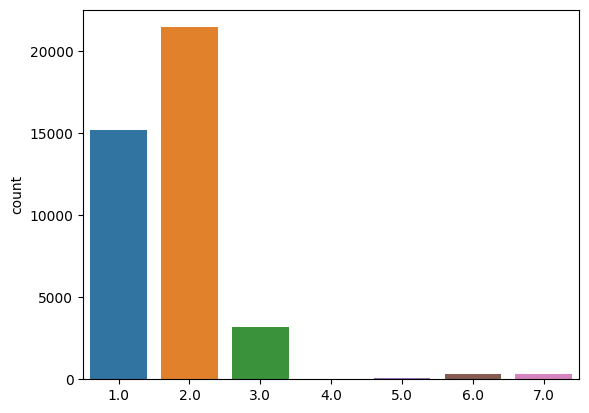

In [87]:
sns.countplot(x = y_pred)

In [88]:
pred_prob_test.to_csv("model/group13knn.csv", index=False)

Now we prepare for studying Random Forest algorithm

In [33]:
X_train_sub  = X_train[['X1', 'X3', 'X4','X6', 'X10']]
X_train_cat = X_train[['X11']]
X_test_sub = X_test[['X1', 'X3','X4' ,'X6', 'X10']]
X_test_cat = X_test[['X11']]

Filling out the missing values in the categoriacal variable X11

In [42]:
columna = ['X11']
imputer = SimpleImputer(strategy='most_frequent')

X_train[columna] = imputer.fit_transform(X_train[columna])

X_train_cat = pd.DataFrame(X_train[columna])

In [43]:
columnas = ['X1', 'X3', 'X4','X6', 'X10']

# Rellenar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train[columnas] = imputer.fit_transform(X_train[columnas])

# Convertir a un array de numpy
X_train_sub = pd.DataFrame(X_train[columnas])

We are gonna study now another algorithms such as Random Forest

In [36]:
X_train_num  = X_train_sub[['X1', 'X3', 'X6', 'X10']]
X_train_cat = X_train[['X11']]
X_test_num = X_test[['X1', 'X3','X6', 'X10']]
X_test_cat = X_test[['X11']]

ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)

X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)
param_grid_rf = {
    'criterion': ['log_loss', 'gini', 'entropy'],
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

grids = {
    'Random Forest': RandomizedSearchCV(rf, param_grid_rf, scoring='neg_log_loss', **default_grid_params),
}

results = []

for model_name, model in grids.items():
    print('Running', model_name)
    # Note that by default the argument `refit` of `GridSearchCV` is set to True, so that the best estimator 
    # is refit on the whole training set.
    model.fit(X_train_sub, y_train)


    y_pred_proba = model.predict_proba(X_train_sub)
    test_log_loss = log_loss(y_train, y_pred_proba, labels=model.classes_)
    print('Log loss:', test_log_loss)

    results.append([test_log_loss])
    pred_prob_test = pd.DataFrame(model.predict_proba(X_test_num))
    pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
    idx = pred_prob_test.index
    pred_prob_test.insert(0, 'id', idx)
    pred_prob_test.head()
    
    print(f'Best hyperparameters: {model.best_params_}')

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Running Random Forest


KeyboardInterrupt: 

We compute now the algorithm with those best hyperparametres

In [44]:
columna = ['X11']
imputer = SimpleImputer(strategy='most_frequent')

X_train[columna] = imputer.fit_transform(X_train[columna])

X_train_cat = pd.DataFrame(X_train[columna])

columnas = ['X1', 'X3','X4', 'X6', 'X10']

# Rellenar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train[columnas] = imputer.fit_transform(X_train[columnas])

# Convertir a un array de numpy
X_train_sub = pd.DataFrame(X_train[columnas])

In [45]:
X_train_num  = X_train_sub[['X1', 'X3','X6', 'X10']]
X_train_cat = X_train[['X11']]
X_test_num = X_test[['X1', 'X3', 'X6','X10']]
X_test_cat = X_test[['X11']]

ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)

X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)

model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4,
                            max_depth=None, criterion='log_loss')
model.fit(X_train_sub, y_train)


y_pred_proba = model.predict_proba(X_train_sub)
test_log_loss = log_loss(y_train, y_pred_proba, labels=model.classes_)
print('Log loss:', test_log_loss)

results.append([test_log_loss])
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_num))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Log loss: 0.30242770080183873


,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.248770,0.750593,0.000005,0.000000,0.000435,0.000005,0.000191
1,1,0.088168,0.906148,0.000005,0.000000,0.005483,0.000005,0.000191
2,2,0.647580,0.352420,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.214719,0.749752,0.003606,0.000027,0.018368,0.013512,0.000015
4,4,0.280902,0.690056,0.000057,0.000000,0.000014,0.000000,0.028972


In [46]:
y_pred = model.predict(X_train_sub)

<Axes: ylabel='count'>

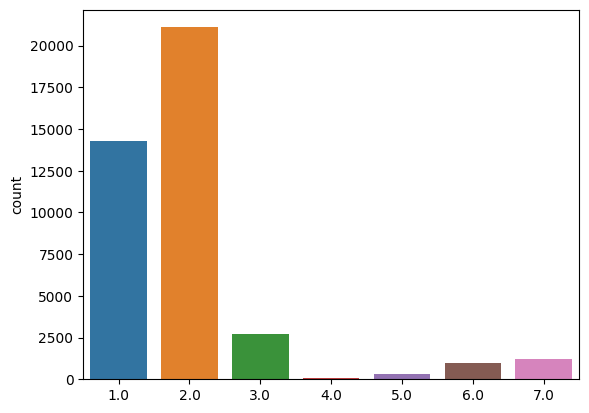

In [47]:
sns.countplot(x = y_pred)

In [48]:
pred_prob_test.to_csv("model/groupe13RF.csv", index=False)

In [30]:
confusion_matrix(y_pred, y_train)

array([[14701,    39,     0,     0,     0,     0,    27],
       [  110, 19762,    15,     0,    71,    18,     2],
       [    4,     6,  2482,    18,     5,    10,     0],
       [    0,     0,     0,   167,     0,     1,     0],
       [    2,     0,     0,     0,   587,     0,     0],
       [    0,     1,     3,     6,     1,  1186,     0],
       [    2,     1,     0,     0,     0,     0,  1405]], dtype=int64)

We are gonna focus on Randon Forest in order to immprove the results

In [9]:
param_range = np.arange(1, 301)


In [10]:
X_train_num  = X_train_sub[['X1', 'X3', 'X4','X6', 'X10']]
X_train_cat = X_train[['X11']]
X_test_num = X_test[['X1', 'X3', 'X6', 'X4','X10']]
X_test_cat = X_test[['X11']]


In [11]:

ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)

X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)


train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X_train_sub, y_train,
    param_name="n_estimators", param_range=param_range,
    cv=5, scoring='neg_log_loss', n_jobs=-1
)

print(train_scores)

# Calcular la media y desviación estándar de las puntuaciones de entrenamiento y validación
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de validación
plt.figure(figsize=(10, 6))
plt.title("Curva de Validación - Random Forest")
plt.xlabel("Número de Árboles")
plt.ylabel("Negativo del Logaritmo de la Pérdida")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_mean, label="Entrenamiento", color="r")
plt.plot(param_range, test_mean, label="Validación", color="b")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="b")
plt.legend(loc="best")
plt.grid(True)
plt.show()

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


We are gonna now study another algorithms and we are gonna take into account another features. First we are gonna do something we should have done before, that is filling all the features with the missing values and applying OneHotEncoder

In [25]:
X_train.isna().sum()

X1     46
X2      0
X3     31
X4      0
X5      0
X6     48
X7      0
X8      0
X9      0
X10     0
X11    38
X12     0
dtype: int64

In [7]:

numeric_variables_missing = ['X1','X2','X3', 'X4', 'X5', 'X6','X7', 'X8', 'X9', 'X10']

categorical_variables_missing = ['X11','X12']

categorical_variables = ['X11', 'X12']
imputer = SimpleImputer(strategy='mean')
X_train[numeric_variables_missing] = imputer.fit_transform(X_train[numeric_variables_missing])
imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_variables_missing] = imputer.fit_transform(X_train[categorical_variables_missing])

X_train['X11'] = X_train['X11'].astype('category')
X_train['X12'] = X_train['X12'].astype('category')


In [8]:
X_test.isna().sum()

Unnamed: 0    0
X1            0
X2            0
X3            0
X4            0
X5            0
X6            0
X7            0
X8            0
X9            0
X10           0
X11           0
X12           0
dtype: int64

We are gonna study the Linear Discriminant Analysis now

In [48]:
X_train_num  = X_train[['X1','X2','X3','X4','X5','X6', 'X7', 'X8', 'X9']]
X_train_cat = X_train[['X11']]
X_test_num = X_test[['X1','X2','X3','X4','X5','X6', 'X7', 'X8', 'X9']]
X_test_cat = X_test[['X11']]



In [49]:
ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)

X_train_categorical_encoded.shape
X_test_cat_encoded.shape


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(17431, 4)

In [50]:
X_train_num = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)


In [51]:
default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)
lda = LinearDiscriminantAnalysis()
param_grid_lda = {}
grids = {
    'Linear Discriminant Analysis': RandomizedSearchCV(lda, param_grid_lda, scoring='neg_log_loss', **default_grid_params),
}

for model_name, model in grids.items():
    print('Running', model_name)
    # Note that by default the argument `refit` of `GridSearchCV` is set to True, so that the best estimator 
    # is refit on the whole training set.
    model.fit(X_train_num, y_train)



    y_pred_proba = model.predict_proba(X_train_num)
    test_log_loss = log_loss(y_train, y_pred_proba, labels=model.classes_)
    print('Log loss:', test_log_loss)

    
    print(f'Best hyperparameters: {model.best_params_}')

    pred_prob_test = pd.DataFrame(model.predict_proba(X_test_num))
    pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
    idx = pred_prob_test.index
    pred_prob_test.insert(0, 'id', idx)




Running Linear Discriminant Analysis


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Log loss: 0.899109069998751
Best hyperparameters: {}


In [52]:
pred_prob_test.head()

,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.147100,0.843143,4.992717e-06,2.661504e-13,0.009525,1.606652e-05,0.000211
1,1,0.100149,0.865061,1.995906e-05,3.807241e-12,0.034609,2.584669e-05,0.000135
2,2,0.574129,0.415960,8.529654e-08,5.063083e-15,0.000869,3.137367e-07,0.009041
3,3,0.147437,0.830682,4.253229e-05,1.466901e-12,0.021148,2.650824e-04,0.000425
4,4,0.585734,0.316710,5.233848e-07,1.001095e-13,0.002573,4.059705e-07,0.094983


In [53]:
y_pred = model.predict(X_train_num)

<Axes: ylabel='count'>

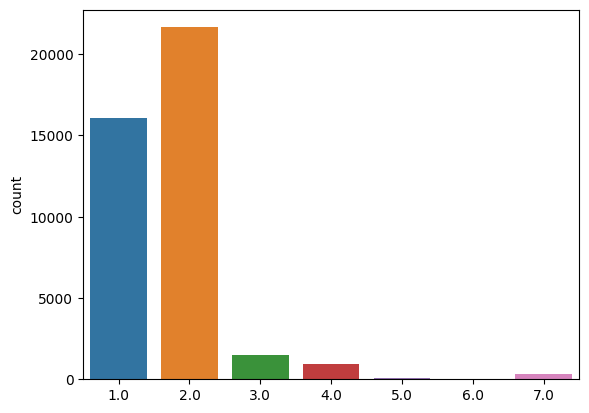

In [54]:
sns.countplot(x = y_pred)

In [55]:
confusion_matrix(y_train, y_pred)

array([[10697,  4019,     0,     0,     0,     0,   103],
       [ 4177, 15416,   127,    78,     6,     3,     2],
       [    0,   975,   905,   543,    70,     7,     0],
       [    0,     0,    20,   171,     0,     0,     0],
       [    0,   664,     0,     0,     0,     0,     0],
       [    0,   560,   470,   176,     4,     5,     0],
       [ 1212,    22,     0,     0,     0,     0,   200]], dtype=int64)

In [56]:
pred_prob_test.to_csv("model/group13lda.csv", index=False)

We are gonna use SelectKBest

In [100]:
X_train_num = X_train[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X_train_num)

select = SelectKBest(chi2, k=5)
z = select.fit(scaled, y_train)
    

In [98]:
z.get_feature_names_out()

array(['x0', 'x2', 'x3', 'x5', 'x9'], dtype=object)

We are gonna study the gradient boosting algorithm

In [18]:
X_train_num  = X_train[['X1','X3', 'X6']]
X_train_cat = X_train[['X11']]
X_test_num = X_test[['X1','X3', 'X6']]
X_test_cat = X_test[['X11']]

In [19]:
ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
X_train_num = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)

In [23]:
gb = GradientBoostingClassifier()
default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)
param_grid_gb = {
    'loss': ['log_loss'],
    'learning_rate': [0.02, 0.1, 0.5],
    'n_estimators': [100, 200, 300],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [None, 2, 5, 10],
}

grids = {
    'Gradient Boosting': RandomizedSearchCV(gb, param_grid_gb, scoring='neg_log_loss', **default_grid_params),
}

for model_name, model in grids.items():
    print('Running', model_name)
    # Note that by default the argument `refit` of `GridSearchCV` is set to True, so that the best estimator 
    # is refit on the whole training set.
    model.fit(X_train_num, y_train)



    y_pred_proba = model.predict_proba(X_train_num)
    test_log_loss = log_loss(y_train, y_pred_proba, labels=model.classes_)
    print('Log loss:', test_log_loss)
    
    print(f'Best hyperparameters: {model.best_params_}')

Running Gradient Boosting


Implementing Naive Bayes

In [33]:
X_train_num  = X_train[['X1','X3','X4','X6', 'X10', 'X7']]
X_train_cat = X_train[['X11']]
X_test_num = X_test[['X1','X3','X4','X6', 'X10', 'X7']]
X_test_cat = X_test[['X11']]


In [34]:
ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
X_train_num = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)

In [36]:
param_grid_nb = {}


In [48]:
nb = GaussianNB()

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)
model = RandomizedSearchCV(nb, param_grid_nb, scoring='neg_log_loss', **default_grid_params)

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

model.fit(X_train_num, y_train)

y_pred = model.predict(X_test_num)


y_pred_proba = model.predict_proba(X_train_num)
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_num))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)

test_log_loss = log_loss(y_train, y_pred_proba, labels=model.classes_)
print('Log loss:', test_log_loss)
print(f'Best hyperparameters: {model.best_params_}')

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Log loss: 1.3802023277785136
Best hyperparameters: {}


In [49]:
pred_prob_test.to_csv("model/group13nb.csv", index=False)

<Axes: ylabel='count'>

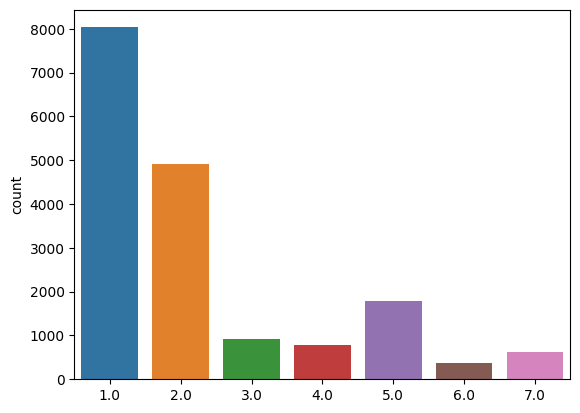

In [44]:
sns.countplot(x = y_pred)

In this section we will devolope the next idea: We are gonna split our train.csv in order to have two different type of data and make like one y_test

In [53]:
df_train = pd.read_csv('data/train.csv')
df_train.dropna(subset=['Y'], inplace=True)

X = df_train.drop('Y', axis = 1)
y = df_train['Y']


X_test_prueb = pd.read_csv('data/Xtest.csv')
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,3215.0,206.0,8.0,127.0,14.0,5588.0,215.0,248.0,168.0,1057.0,T1,T29,1.0
1,3022.0,18.0,7.0,0.0,0.0,3012.0,215.0,226.0,148.0,1476.0,T1,T23,1.0
2,3008.0,18.0,19.0,382.0,92.0,4715.0,201.0,197.0,127.0,3616.0,T1,T29,1.0
3,2595.0,296.0,24.0,85.0,28.0,1252.0,144.0,224.0,216.0,780.0,T3,T33,6.0
4,3261.0,87.0,4.0,42.0,-2.0,3719.0,226.0,233.0,142.0,3784.0,T1,T38,7.0


In [54]:
X = X.astype({'X11':'category', 'X12': 'category'})
X_test_prueb = X_test_prueb.astype({'X11':'category', 'X12':'category'})

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
columna = ['X11']
imputer = SimpleImputer(strategy='most_frequent')

X_train[columna] = imputer.fit_transform(X_train[columna])
X_test[columna] = imputer.fit_transform(X_test[columna])

X_train_cat = pd.DataFrame(X_train[columna])
X_test_cat = pd.DataFrame(X_test[columna])

columnas = ['X1', 'X3','X4', 'X6', 'X10']

# Rellenar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train[columnas] = imputer.fit_transform(X_train[columnas])
X_test[columnas] = imputer.fit_transform(X_test[columnas])

# Convertir a un array de numpy
X_train_sub = pd.DataFrame(X_train[columnas])
X_test_sub = pd.DataFrame(X_test[columnas])

In [57]:
X_test_sub.dtypes

X1     float64
X3     float64
X4     float64
X6     float64
X10    float64
dtype: object

In [58]:
X_train_num  = X_train_sub[['X1', 'X3','X4','X6','X10']]
X_train_cat = X_train[['X11']]
X_test_num = X_test_sub[['X1', 'X3','X4', 'X6','X10']]
X_test_cat = X_test[['X11']]




ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)


#The real test
X_test_prueb_num = X_test_prueb[['X1', 'X3','X4' ,'X6', 'X10']]
X_test_prueb_cat = X_test_prueb[['X11']]
X_prueb_cat_encoded = ohe.fit_transform(X_test_prueb_cat)

X_test_final = np.concatenate((X_test_prueb_num, X_prueb_cat_encoded), axis=1)



X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)



param_grid_rf = {
    'criterion': ['gini', 'entropy','log_loss'],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

rf = RandomForestClassifier()

model = RandomizedSearchCV(rf, param_grid_rf, scoring='neg_log_loss', **default_grid_params)
model.fit(X_train_sub, y_train)

results = []
y_pred_proba = model.predict_proba(X_test_num)
test_log_loss = log_loss(y_test, y_pred_proba, labels=model.classes_)
print('Log loss:', test_log_loss)

y_pred = model.predict(X_test_num)
test_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', test_accuracy)

results.append([test_log_loss,test_accuracy])
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_final))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Log loss: 0.4239276531463472
Accuracy: 0.8319182970345761


,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.028607,0.971393,0.000000,0.0,0.000000,0.000000,0.000000
1,1,0.014167,0.979000,0.000000,0.0,0.006833,0.000000,0.000000
2,2,0.689462,0.310538,0.000000,0.0,0.000000,0.000000,0.000000
3,3,0.125530,0.813884,0.002155,0.0,0.025192,0.033221,0.000018
4,4,0.154929,0.828571,0.000000,0.0,0.000000,0.000000,0.016500


In [59]:
print(f'Best hyperparameters: {model.best_params_}')

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}


In [60]:
pred_prob_test.to_csv("model/group13RFmodified1.csv", index=False)

In [62]:
y_pred2 = model.predict(X_test_final)

<Axes: ylabel='count'>

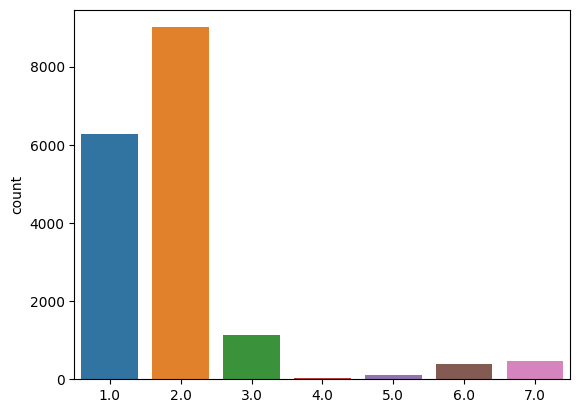

In [16]:
X_train_num  = X_train_sub[['X1', 'X3','X4','X6', 'X10']]
X_train_cat = X_train[['X11']]
X_test_num = X_test_sub[['X1', 'X3','X4' ,'X6','X10']]
X_test_cat = X_test[['X11']]




ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)


#The real test
X_test_prueb_num = X_test_prueb[['X1', 'X3', 'X4', 'X6', 'X10']]
X_test_prueb_cat = X_test_prueb[['X11']]
X_prueb_cat_encoded = ohe.fit_transform(X_test_prueb_cat)

X_test_final = np.concatenate((X_test_prueb_num, X_prueb_cat_encoded), axis=1)



X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


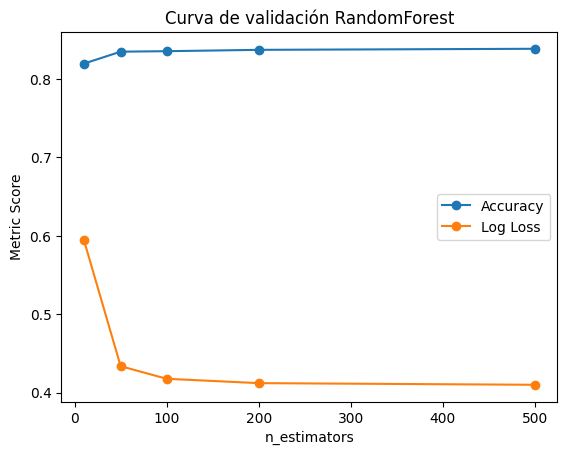

In [43]:
n_estimators_values = [10, 50, 100, 200, 500]

# Lista para almacenar los resultados
val_scores = []
log_loss_scores = []

# Entrena los modelos y evalúa el rendimiento
for n_estimators in n_estimators_values:
    model = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=2, min_samples_split=2, max_depth=None, criterion='log_loss')
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_num)
    y_pred_proba = model.predict_proba(X_test_num)
    score = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    val_scores.append(score)
    log_loss_scores.append(loss)

# Grafica la curva de validación
plt.plot(n_estimators_values, val_scores, marker='o', label='Accuracy')
plt.plot(n_estimators_values, log_loss_scores, marker='o', label='Log Loss')
plt.xlabel('n_estimators')
plt.ylabel('Metric Score')
plt.title('Curva de validación RandomForest')
plt.legend()
plt.show()

In [18]:
model = RandomForestClassifier(n_estimators=500)
model.fit(X_train_sub, y_train)
y_pred = model.predict(X_test_num)
y_pred_proba = model.predict_proba(X_test_num)

In [19]:
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_final))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()

,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.240,0.760,0.0,0.0,0.000,0.000,0.000
1,1,0.064,0.936,0.0,0.0,0.000,0.000,0.000
2,2,0.740,0.260,0.0,0.0,0.000,0.000,0.000
3,3,0.234,0.738,0.0,0.0,0.006,0.022,0.000
4,4,0.138,0.836,0.0,0.0,0.000,0.000,0.026


In [43]:
pred_prob_test.to_csv("model/group13RFmodified.csv", index=False)

ON ESSAY DE FAIRE AVEC KNN

In [44]:
df_train = pd.read_csv('data/train.csv')
df_train.dropna(subset=['Y'], inplace=True)

X = df_train.drop('Y', axis = 1)
y = df_train['Y']


X_test_prueb = pd.read_csv('data/Xtest.csv')
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,3215.0,206.0,8.0,127.0,14.0,5588.0,215.0,248.0,168.0,1057.0,T1,T29,1.0
1,3022.0,18.0,7.0,0.0,0.0,3012.0,215.0,226.0,148.0,1476.0,T1,T23,1.0
2,3008.0,18.0,19.0,382.0,92.0,4715.0,201.0,197.0,127.0,3616.0,T1,T29,1.0
3,2595.0,296.0,24.0,85.0,28.0,1252.0,144.0,224.0,216.0,780.0,T3,T33,6.0
4,3261.0,87.0,4.0,42.0,-2.0,3719.0,226.0,233.0,142.0,3784.0,T1,T38,7.0


In [45]:
X = X.astype({'X11':'category', 'X12': 'category'})
X_test_prueb = X_test_prueb.astype({'X11':'category', 'X12':'category'})

In [51]:
columna = ['X11']
imputer = SimpleImputer(strategy='most_frequent')

X_train[columna] = imputer.fit_transform(X_train[columna])
X_test[columna] = imputer.fit_transform(X_test[columna])

X_train_cat = pd.DataFrame(X_train[columna])
X_test_cat = pd.DataFrame(X_test[columna])

columnas = ['X1', 'X3','X4', 'X6', 'X9', 'X10']

# Rellenar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train[columnas] = imputer.fit_transform(X_train[columnas])
X_test[columnas] = imputer.fit_transform(X_test[columnas])

# Convertir a un array de numpy
X_train_sub = pd.DataFrame(X_train[columnas])
X_test_sub = pd.DataFrame(X_test[columnas])

In [52]:
X_train_num  = X_train_sub[['X1', 'X3','X4','X6','X9', 'X10']]
X_train_cat = X_train[['X11']]
X_test_num = X_test_sub[['X1', 'X3','X4', 'X6','X9','X10']]
X_test_cat = X_test[['X11']]




ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)


#The real test
X_test_prueb_num = X_test_prueb[['X1', 'X3','X4' ,'X6','X9','X10']]
X_test_prueb_cat = X_test_prueb[['X11']]
X_prueb_cat_encoded = ohe.fit_transform(X_test_prueb_cat)

X_test_final = np.concatenate((X_test_prueb_num, X_prueb_cat_encoded), axis=1)



X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)


param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20, 50, 100],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

knn = KNeighborsClassifier()

model = RandomizedSearchCV(knn, param_grid_knn, scoring='neg_log_loss', **default_grid_params)
model.fit(X_train_sub, y_train)

results = []
y_pred_proba = model.predict_proba(X_test_num)
test_log_loss = log_loss(y_test, y_pred_proba, labels=model.classes_)
print('Log loss:', test_log_loss)

y_pred = model.predict(X_test_num)
test_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', test_accuracy)

results.append([test_log_loss,test_accuracy])
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_final))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Log loss: 0.5391230325524583
Accuracy: 0.8033714777900824


,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.139594,0.860406,0.0,0.0,0.0,0.0,0.000000
1,1,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000
2,2,0.609349,0.390651,0.0,0.0,0.0,0.0,0.000000
3,3,0.144810,0.855190,0.0,0.0,0.0,0.0,0.000000
4,4,0.385512,0.500332,0.0,0.0,0.0,0.0,0.114156


NOW LOGISTIC REGRESSIOn

In [65]:
df_train = pd.read_csv('data/train.csv')
df_train.dropna(subset=['Y'], inplace=True)

X = df_train.drop('Y', axis = 1)
y = df_train['Y']


X_test_prueb = pd.read_csv('data/Xtest.csv')
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,3215.0,206.0,8.0,127.0,14.0,5588.0,215.0,248.0,168.0,1057.0,T1,T29,1.0
1,3022.0,18.0,7.0,0.0,0.0,3012.0,215.0,226.0,148.0,1476.0,T1,T23,1.0
2,3008.0,18.0,19.0,382.0,92.0,4715.0,201.0,197.0,127.0,3616.0,T1,T29,1.0
3,2595.0,296.0,24.0,85.0,28.0,1252.0,144.0,224.0,216.0,780.0,T3,T33,6.0
4,3261.0,87.0,4.0,42.0,-2.0,3719.0,226.0,233.0,142.0,3784.0,T1,T38,7.0


In [66]:
X = X.astype({'X11':'category', 'X12': 'category'})
X_test_prueb = X_test_prueb.astype({'X11':'category', 'X12':'category'})

In [67]:
columna = ['X11']
imputer = SimpleImputer(strategy='most_frequent')

X_train[columna] = imputer.fit_transform(X_train[columna])
X_test[columna] = imputer.fit_transform(X_test[columna])

X_train_cat = pd.DataFrame(X_train[columna])
X_test_cat = pd.DataFrame(X_test[columna])

columnas = ['X1', 'X3','X4', 'X6', 'X9', 'X10']

# Rellenar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train[columnas] = imputer.fit_transform(X_train[columnas])
X_test[columnas] = imputer.fit_transform(X_test[columnas])

# Convertir a un array de numpy
X_train_sub = pd.DataFrame(X_train[columnas])
X_test_sub = pd.DataFrame(X_test[columnas])

In [68]:
X_train_num  = X_train_sub[['X1', 'X3','X4','X6','X9', 'X10']]
X_train_cat = X_train[['X11']]
X_test_num = X_test_sub[['X1', 'X3','X4', 'X6','X9','X10']]
X_test_cat = X_test[['X11']]




ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)


#The real test
X_test_prueb_num = X_test_prueb[['X1', 'X3','X4' ,'X6','X9','X10']]
X_test_prueb_cat = X_test_prueb[['X11']]
X_prueb_cat_encoded = ohe.fit_transform(X_test_prueb_cat)

X_test_final = np.concatenate((X_test_prueb_num, X_prueb_cat_encoded), axis=1)



X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)


param_grid_lr_skb = {
    'skb__k': [3, 5, 7, 9],
    'clf__penalty': ['l2'],
    'clf__fit_intercept': [True, False],
}

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

lr_skb = Pipeline([('skb', SelectKBest()), ('clf', LogisticRegression(max_iter=1000))])

model = RandomizedSearchCV(lr_skb, param_grid_lr_skb, scoring='neg_log_loss', **default_grid_params)
model.fit(X_train_sub, y_train)

results = []
y_pred_proba = model.predict_proba(X_test_num)
test_log_loss = log_loss(y_test, y_pred_proba, labels=model.classes_)
print('Log loss:', test_log_loss)

y_pred = model.predict(X_test_num)
test_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', test_accuracy)

results.append([test_log_loss,test_accuracy])
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_final))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_sele

Log loss: 0.9635100286145513
Accuracy: 0.6489479512735327


,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.251425,0.677400,0.013163,0.000899,0.007743,0.006331,0.043039
1,1,0.224739,0.688996,0.022684,0.001869,0.013075,0.006321,0.042317
2,2,0.469212,0.476881,0.003297,0.000153,0.002248,0.004134,0.044076
3,3,0.225024,0.660403,0.039550,0.004014,0.022915,0.005760,0.042335
4,4,0.610566,0.328024,0.009299,0.000697,0.006947,0.002324,0.042144
